In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-05-26 12:17:39,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-nrni_0wf', purging
2023-05-26 12:17:39,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ajl3agix', purging
2023-05-26 12:17:39,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-qqo7x24k', purging
2023-05-26 12:17:39,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_7qwirba', purging
2023-05-26 12:17:39,253 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ywvb4abf', purging
2023-05-26 12:17:39,253 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-k70rj1_t', purging
2023-05-26 12:17:39,253 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5nlb4z1u', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44549,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:44983,Total threads: 1
Dashboard: http://127.0.0.1:40131/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:37217,


In [2]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

In [4]:
# Load control simulation 
preprocess = lambda ds: croco_sellonlatbox(ds[['u','v','h']],  360-72, 360-71.35, -30.32, -30)
pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y*.nc'))
control_avg      = xr.open_mfdataset(pathsavg_control, parallel=True, preprocess=preprocess)
control_avg      = fix_crocotime(control_avg, YORIG='1949-12-30 23:59:50')
control_avg      = center_crocogrid(control_avg, control_avg.keys()).load()#.isel(time=control_avg.time.dt.month==5)

In [5]:
blkplv = xr.open_dataset('~/storage/SEQUIA/crocod0_blk_PLV.nc')
blkplv.coords['bulk_time'] = blkplv.bulk_time + pd.to_datetime('1950-01-01')
blkplv = blkplv.reindex({'bulk_time':control_avg.time.values}, method='nearest')

In [37]:
upwelling   = blkplv.vwnd.where(blkplv.vwnd>5).to_series().dropna().sort_values(ascending=False).head(30).index
downwelling = blkplv.vwnd.where(blkplv.vwnd<-5).to_series().dropna().sort_values(ascending=False).tail(30).index
relaxation  = blkplv.vwnd.where(blkplv.vwnd>-0.4).where(blkplv.vwnd<0.4).to_series().dropna().head(30).index

upwelling_compound  = control_avg.reindex({'time':upwelling}, method='nearest').mean('time')
relaxation_compound = control_avg.reindex({'time':relaxation}, method='nearest').mean('time')
downwelling_compound = control_avg.reindex({'time':downwelling}, method='nearest').mean('time')

Text(0.5, 1.0, 'Downwelling')

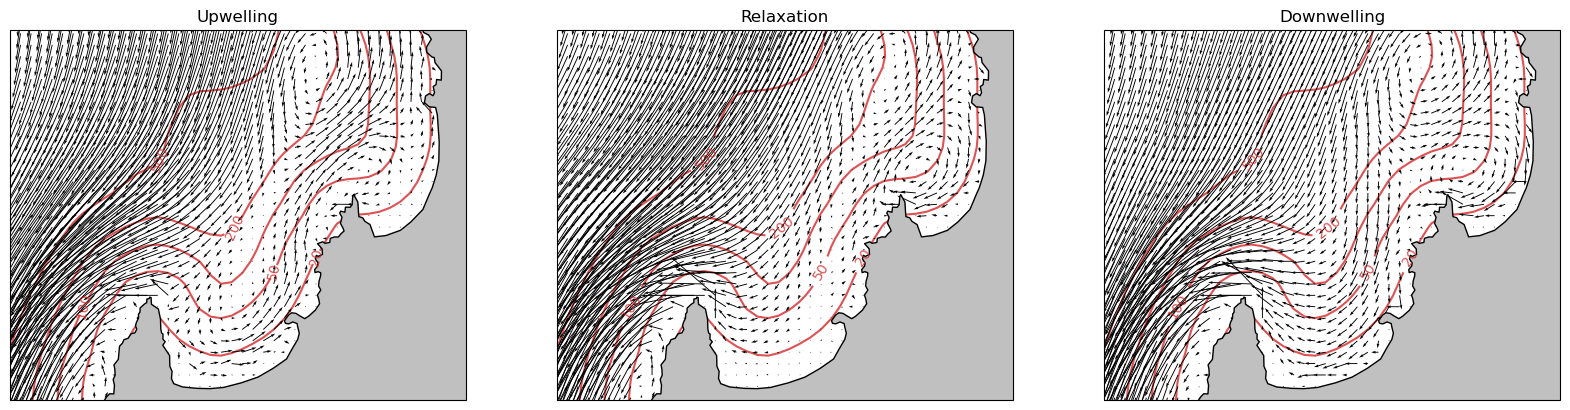

In [42]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10), facecolor='w', dpi=100, subplot_kw={'projection':ccrs.PlateCarree()})
for axis in ax.ravel():
    axis.set_extent([-71.75,-71.35,-30.31,-30.05])
    cl=axis.contour(upwelling_compound.lon_rho, upwelling_compound.lat_rho, upwelling_compound.h,
                    levels=[20,50,100,200,500], zorder=0, colors='tab:red', alpha=0.8)
    axis.clabel(cl, cl.levels)
    coastline.plot(ax=axis, color='silver', edgecolor='k', zorder=1)
    
ax[0].quiver(upwelling_compound.lon_rho.values, upwelling_compound.lat_rho.values,
             upwelling_compound.u.mean('s_rho').values, upwelling_compound.v.mean('s_rho').values,
             transform=ccrs.PlateCarree(), zorder=0, scale=0.8, width=0.002)

ax[1].quiver(relaxation_compound.lon_rho.values, relaxation_compound.lat_rho.values,
             relaxation_compound.u.mean('s_rho').values, relaxation_compound.v.mean('s_rho').values,
             transform=ccrs.PlateCarree(), zorder=0, scale=0.8, width=0.002)


ax[2].quiver(downwelling_compound.lon_rho.values, downwelling_compound.lat_rho.values,
             downwelling_compound.u.mean('s_rho').values, downwelling_compound.v.mean('s_rho').values,
             transform=ccrs.PlateCarree(), zorder=0, scale=0.8, width=0.002)

ax[0].set_title('Upwelling')
ax[1].set_title('Relaxation')
ax[2].set_title('Downwelling')